I read in the tidy dataframe with clean values that I produced in the previous project and stored as a pickled file from disk, using the "read_pickle()" method:

In [1]:
import pandas as pd
df = pd.read_pickle('EU_industry_production_dataframe_clean.pkl')

As a reminder, let's have a look at the dataframe:

In [2]:
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27936 entries, (1953-01-01 00:00:00, AT) to (2017-08-01 00:00:00, UK)
Data columns (total 2 columns):
production_index    8744 non-null float64
flags               27936 non-null category
dtypes: category(1), float64(1)
memory usage: 333.9+ KB
                         production_index flags
time       country_code                        
1953-01-01 AT                         NaN      
           BA                         NaN      
           BE                         NaN      
           BG                         NaN      
           CY                         NaN      


The dataframe has only 8744 non-null production index values, which is only a third of all entries.

Let's see how the values are distributed. A quick overview can be gained using the "describe()" method:

In [3]:
print(df.describe())

       production_index
count       8744.000000
mean          97.614010
std           21.815713
min            9.900000
25%           89.900000
50%          100.600000
75%          109.900000
max          190.500000


For all numeric columns (there is just one in this dataframe), I get basic statistics like the mean, the median ("50%" -- the 50th percentile), the standard deviation ("std") or minimum/maximum values.

Both the median and the mean are suspiciously close to 100, which is the value that was assigned to the production index for the reference year 2010, according to the documentation (http://ec.europa.eu/eurostat/cache/metadata/en/sts_esms.htm#unit_measure1503478993192, Section 3.9). Either the industry production has been stagnating for a long time, or the missing values are clustered at earlier decades.

Also the minimum value, "9.9", is quite small. This could be real (for example for a country that developed quickly and for which the data reach back a long time), but also an outlier. Let's take a closer look at the distribution with a histogram plot. This can be done directly using Pandas with the "hist()" method, building on the matplotlib package:

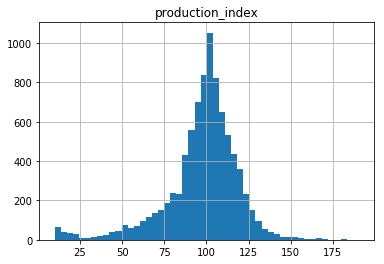

In [4]:
import matplotlib.pyplot as plt  # Import Python plotting package
df.hist(bins=50)  # Define the histogram, use 50 bins
plt.show()        # Draw the figure

The main distribution is peaked at about 100, but is quickly falling off to the flanks (compared to a Gaussian distribution) and is asymmetric.

Interestingly, the minimum value seems to belong to a small distribution disjoint from the main distribution of the production index values. The cut-off is at about 25. Do these values have something in common? Do they belong only to certain countries? Do they appear at the beginning of the time series? Let's find out!

First, I construct a new dataframe that only contains the rows with the low production index values beneath the threshold of 25. This I can accomplish using a Boolean mask:

In [5]:
df_low = df[df['production_index']<=25].sort_index()
df_low.info()
print(df_low.head())
print(df_low.tail())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 169 entries, (1980-01-01 00:00:00, IE) to (1994-01-01 00:00:00, IE)
Data columns (total 2 columns):
production_index    169 non-null float64
flags               169 non-null category
dtypes: category(1), float64(1)
memory usage: 8.5+ KB
                         production_index flags
time       country_code                        
1980-01-01 IE                        11.0      
1980-02-01 IE                        10.4      
1980-03-01 IE                        10.5      
1980-04-01 IE                        10.7      
1980-05-01 IE                        10.6      
                         production_index flags
time       country_code                        
1993-09-01 IE                        24.1      
1993-10-01 IE                        24.0      
1993-11-01 IE                        24.0      
1993-12-01 IE                        24.9      
1994-01-01 IE                        24.7      


Hmm, does this mean that there is only one country index -- 'IE' for Ireland? I can access the "country_code" level of the index values and find all distinct ones with the "unique()" method, like this:

In [6]:
print(df_low.index.get_level_values('country_code').unique())

Index(['IE'], dtype='object', name='country_code')


These extreme values do indeed belong all to Ireland! Let's plot the development of the Irish industry production index for the whole data period:

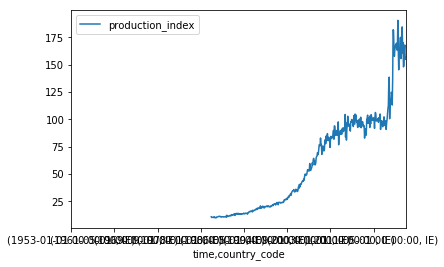

In [7]:
df.loc[(slice(None),'IE'),:].plot()  # Select Ireland and define line plot
plt.show()                           # Draw the figure

The x axis looks horrible and needs to be fixed to be able to see something. The problem is that the whole MultiIndex ('time','country_code') is used for the x axis. However, I only want the time to be on the x axis. This can be done by first making the "country_code" index part an ordinary column, using the "unstack(level=1)" command, before applying the "plot()" method. I also make it clear to pandas that "production_index" should be the y axis by passing this column name to the "plot()" method:

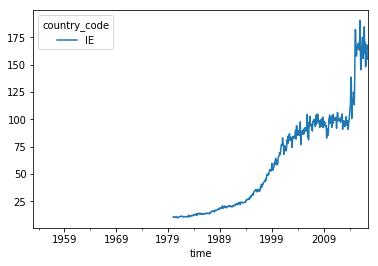

In [8]:
df.loc[(slice(None),'IE'),:].unstack(level=1).plot(y='production_index')
plt.show()

This looks much better! However, I should label the axes correctly:

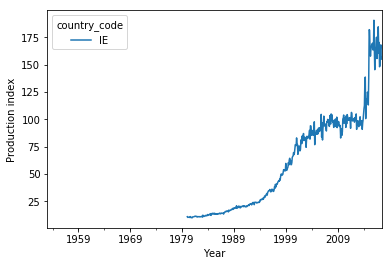

In [9]:
df.loc[(slice(None),'IE'),:].unstack(level=1).plot(y='production_index')
plt.xlabel('Year')
plt.ylabel('Production index')
plt.show()

So the low manufacturing production index values are no outliers due to bad data but reflect the enormous growth of the Irish economy in the recent decades. I can also see that there is no data before 1980 -- that is almost half the data period!

That brings me back to the question if the missing values are in general clustered at the beginning of the dataset. I count the number of missing values for each time step, store the result in a dataseries, divide by the 36 "country_code" values and plot the percentage:

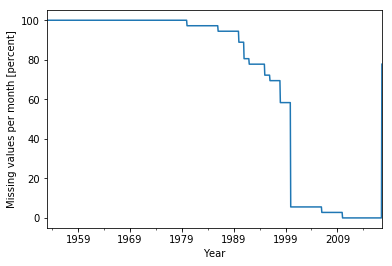

In [10]:
import numpy as np
missing = df['production_index'].isnull().groupby('time').sum()  # Count missing values (NaN) for each month
missing_percent = missing/36*100                                 # Convert into percent values (there are 36 country_code values)
missing_percent.plot()                                           # Plot command
plt.xlabel('Year')                                               # Fix labels
plt.ylabel('Missing values per month [percent]')
plt.show()                                                       # Draw plot

There is no data at all before 1980! Apparently, Ireland is the country for which the data reaches back the longest. About half of the countries kick in over the course of the next 20 years, and most of the other half in 2000. This means that for a comparison between the different countries, I am confined to the period 2000--2017.

For a quick overview, let me plot all curves on top of each other:

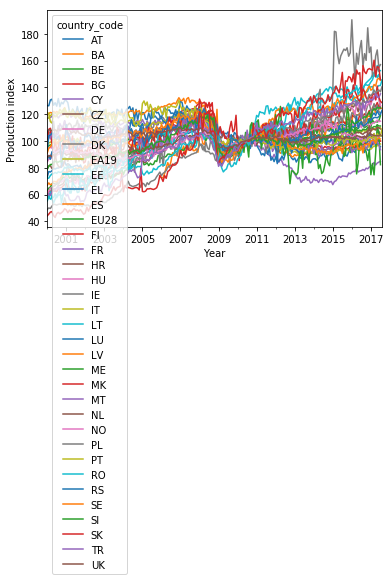

In [11]:
df.loc[(slice('2000','2017'),slice(None)),:].unstack(level=1).plot(y='production_index')
plt.xlabel('Year')
plt.ylabel('Production index')
plt.show()

Well, this looks ugly with such a long legend. Also, the line colors cycle through 10 values before repeating. This makes it impossible to unambiguously relate the entries in the legend to the lines. Let me clean the plot up a bit:

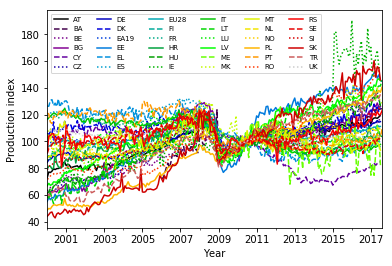

In [19]:
fig, ax = plt.subplots()        # Create figure and axes objects

# Reset line properties to avoid ambiguity between different lines:
ax.set_prop_cycle(color=plt.cm.nipy_spectral(np.linspace(0,1,36)),linestyle=['-','--',':']*12)

# Create the plot:
ax = df.loc[(slice('2000','2017'),slice(None)),:].unstack(level=1).plot(y='production_index',ax=ax)
plt.xlabel('Year')
plt.ylabel('Production index')
ax.legend(ncol=6, fontsize=7)   # Adjust shape (four columns instead of one) and font size of legend
plt.show()

This plot is still a bit of overkill with 36 lines, but it provides a synoptic view for the EU manufacturing production development in the given period.

Apparently, there is a wide range of dynamics covered by the different countries in the last 17 years -- reaching from a strong increase of the index (for Slovakia) to a slight decline (Finland) and basically anything in between. Note that the curves meet in 2010 at the value 100, since this is how they were normalized.

Most curves show a sudden drop in 2008, in the wake of the financial crisis. This can be seen better in the average over the European Union, the 'EU28':

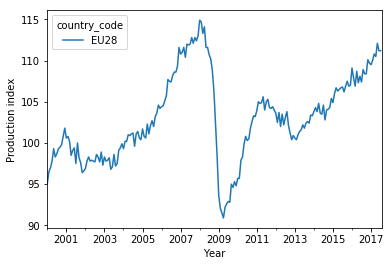

In [22]:
ax = df.loc[(slice('2000','2017'),'EU28'),:].unstack(level=1).plot(y='production_index')
plt.xlabel('Year')
plt.ylabel('Production index')
plt.show()